### 6-channel transfer-learning

In [1]:
%%capture

from __future__ import print_function, division
from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch 
import random
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from torchvision import transforms

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm

import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from torchvision.transforms import RandomVerticalFlip, RandomCrop

from albumentations import RandomCrop, Normalize, HorizontalFlip, Resize
from albumentations import Compose
from albumentations.pytorch import ToTensor

import datetime


In [25]:
import wandb
wandb.init(project="kern", name='rn18-1e-3-2')


W&B Run: https://app.wandb.ai/nuvard/kern/runs/81of66km

In [3]:
DEVICE = torch.device("cuda")

In [4]:

test_device(DEVICE)

In [6]:
set_seed()

In [26]:
IMAGE_SIZE = 128
BATCH_SIZE = 64
PATH = '/project/'
NUM_CLASSES = 6
NAME = 'r18-ft-5-2'
LR = 1e-3

## Подготовка данных

### Загрузка таблиц

In [12]:
data_uf = pd.read_csv(PATH+'data_uf.csv', index_col=0)
data_dc = pd.read_csv(PATH+'data_dc.csv', index_col=0)

In [10]:
temp = check(data_uf)

All is OK!


### Переопределение классов

Нам нужны не все классы, а только некоторые. Пока я подготовлю словари для переименования классов. 

In [13]:
satur_dict = {'не опред.': 0, 'нефтенасыщенные': 1,'битуминозный':2, 'продукт':3, 'пятнисто нефтенасыщенные': 4,'слабо нефтенасыщенные':5 }

In [ ]:
satur_int_dict = {'oil':0, 'unknown':1}

In [ ]:
rock_dict = {"с карбонатными обломками или конкрециями": "с карб. обломками или конкрециями", \
             "пересл. кремнисто-глинистой породы и аргиллита": "пересл. кремн.-глинист. породы и аргиллитa", \
             "пересл. песчаника и глины аргиллитоподобной" : "пересл. песчаника и глины аргиллитоподобн."}

In [ ]:
carbon_dict = {"не карбонатный": 'no_carbon', 'с карбонатными обломками или конкрециями': 'part_carbon', 'слабокарбонатный': 'carbon', \
               'сильнокарбонатный': 'carbon', 'среднекарбонатный':'carbon', 'пятнисто карбонатный':'part_carbon', 'с примесью':'part_carbon'}

In [ ]:
ruin_dict = {"не карбонатный": 'no_carbon', 'с карбонатными обломками или конкрециями': 'part_carbon', 'слабокарбонатный': 'carbon', \
               'сильнокарбонатный': 'carbon', 'среднекарбонатный':'carbon', 'пятнисто карбонатный':'part_carbon', 'с примесью':'part_carbon'}

In [ ]:
apply_class(data,'Saturation', satur_dict)

In [16]:
apply_class(data_uf,'Saturation', satur_dict)
apply_class(data_dc,'Saturation', satur_dict)

## Создание датасета

2 статьи на хабре: от[ snakers4](https://habr.com/ru/post/349068/) и [ternaus](https://habr.com/ru/company/ods/blog/330118/).

Гитхаб: [snakers4](https://github.com/snakers4/spacenet-three), [pretrained resnet with fast.ai for proteins](https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb)


In [13]:
class KernDataset(Dataset):
    """Kern dataset."""

    def __init__(self, csv_file_dc,csv_file_uf, root_dir, transform=None, acc=0.2):
        np.random.seed(42)
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.acc = acc
        self.data_uf = pd.read_csv(csv_file_uf)
        self.labels_path = csv_file_uf
        self.root_dir = root_dir
        self.transform = transform
        self.data_dc = pd.read_csv(csv_file_dc)
    
    def __len__(self):
        return len(self.data_uf)

    def __getitem__(self, idx):
        #print('idx '+str(idx))
        dc_img_name = os.path.join(self.root_dir,
                                self.data_dc.loc[idx, 'Folder']+'/data/'+str(self.data_dc.loc[idx, 'Id'])+'.jpeg')
        
        uf_img_name = os.path.join(self.root_dir,
                                self.data_uf.loc[idx, 'Folder']+'/data/'+str(self.data_uf.loc[idx, 'Id'])+'.jpeg')
        
        layer_width = self.data_dc.loc[idx, "LayerDown"] - self.data_dc.loc[idx, "LayerTop"]
        image_dc = Image.open(dc_img_name)
        image_uf = Image.open(uf_img_name).resize(image_dc.size)
        
        crop_size = min(image_dc.size[1], int(image_dc.size[1]*(self.acc/layer_width))-1)
        
        image_np = np.concatenate((np.array(image_dc),np.array(image_uf)), axis=-1)
        
        transf = RandomCrop( crop_size,image_dc.size[0] )
        image_np = transf(image=image_np)['image']
        
        if (crop_size<IMAGE_SIZE):
            transf = Resize(IMAGE_SIZE, int(image_dc.size[0]*(IMAGE_SIZE/crop_size)+1))
            image_np = transf(image=image_np)['image']
        if (transform is not None):
            augmented = self.transform(image = image_np)['image']
            augmented = torch.from_numpy(np.moveaxis(augmented / (255.0 if augmented.dtype == np.uint8 else 1), -1, 0).astype(np.float32))
            
        label = self.data_dc.loc[idx, 'class']
        #print(label)
        #sample = {'image': image, 'class_name': label}
        return DatasetItem(image=augmented, label=label, id=idx, path=dc_img_name)

Делю датасет на трейн и тест

In [14]:
validation_split = .2
shuffle_dataset = True
random_seed = 42

dataset_size = len(data_uf)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


In [30]:
"""

transform = transforms.Compose(
    [
        #transforms.RandomRotation((5)),
        transforms.RandomResizedCrop((128,128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

"""

def strong_aug(p=0.5):
    return Compose(
      [ RandomCrop(IMAGE_SIZE, IMAGE_SIZE, p=1),
        HorizontalFlip(p=p),
        Normalize([0.4802, 0.4481, 0.3975, 0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262,0.2302, 0.2265, 0.2262])
      ], 
    )

transform = strong_aug(p=0.5)


dataset = KernDataset(csv_file_uf=PATH+'data_uf.csv',csv_file_dc=PATH+'data_dc.csv',
                                    root_dir=PATH, transform = strong_aug(p=0.5))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
#train_dataset_dc, test_dataset_dc = torch.utils.data.random_split(dataset_dc, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=DatasetItem.collate,
    num_workers=4,
    worker_init_fn=set_seed()
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=DatasetItem.collate,
    num_workers=4,
    worker_init_fn=set_seed()
)


In [16]:
temp = next(iter(train_loader))

show!


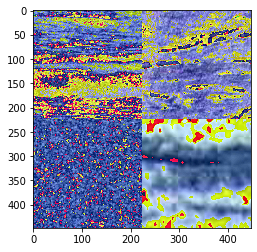

In [37]:
show_batch_image(temp, a=0, b=3)


show!


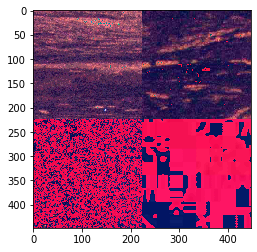

In [38]:
show_batch_image(temp,a = 3,b = 6)


## Обучение модели 


In [17]:
from tqdm import tqdm_notebook

In [18]:
wandb.config.input_size = 128
wandb.config.output_size = 6
wandb.config.name = 'resnet50_all_metrics_1e-4'
wandb.config.lr = LR


In [19]:

def save_files_to_wandb():
    if not os.path.isdir(os.path.join(wandb.run.dir, 'trained_models')):
        os.mkdir(os.path.join(wandb.run.dir, 'trained_models'))
    files_to_copy = ['trained_models/best_1_batch.pth']
    for fname in files_to_copy:
        dest_path = os.path.join(wandb.run.dir, fname)
        if os.path.isdir(fname):
            shutil.copytree(fname, dest_path)
        else:
            shutil.copy2(fname, dest_path)       
            
def log_wandb_images(inputs, labels, output, idx):

    inps_cpu = inputs[0][0:3,:,:].detach().cpu().numpy()
    x_image = Image.fromarray(np.uint8(np.round((x + 0.5)*255)))
    input_images.append(wandb.Image(x_image))
    
    wandb.log({"examples": payload}, commit=False)
    

           

In [20]:
import shutil

In [24]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score
def to_numpy(target):
    return target.detach().cpu().numpy()

def train(model, device, train_loader, optimizer, loss_function, epoch, name = 'resnet-18-finetune'):
    model.train()
    model.to(device)
    correct = 0
    best_f1 = 0
    best_loss_so_far = 10
    running_loss = 0
    for idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data.images.to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        if (idx==0):
            preds=pred.flatten()
            outputs = output
            targets=target
        else:
            preds = torch.cat((preds, pred.flatten()),0)
            targets = torch.cat((targets, target),0)
            outputs = torch.cat((outputs, output),0)
        running_loss += loss.sum().item()   
        correct += pred.eq(target.view_as(pred)).sum().item()
    
    running_loss = running_loss/len(train_loader.dataset)
    f1 = f1_score(to_numpy(preds), to_numpy(targets), average="macro") 
    roc = roc_auc_score(y_score = to_numpy(torch.softmax(outputs, dim=1)), \
                            y_true = to_numpy(torch.nn.functional.one_hot(targets, NUM_CLASSES)), \
                           average = 'macro')
    ap = precision_score(to_numpy(preds), to_numpy(targets), average="macro")
    
    wandb.log({'Train loss': running_loss, 'F1': f1, "ROC-AUC": roc,\
               'AP': ap}, step=epoch)
   
    print(
        "Train Epoch: {} \tLoss: {:.6f}    F1: {:.4f}    ROC-AUC: {:.4f}".format(
            epoch, running_loss, f1, roc
        )
    )
    
    if running_loss < best_loss_so_far:
        best_loss_so_far = loss
        wandb.run.summary['Best train loss'] = loss
        wandb.run.summary['Best epoch'] = epoch
        wandb.save(os.path.join(wandb.run.dir, name+'.h5'))
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, "trained_models/" + name +".pth")
    

                
    
def test(model, device, test_loader, loss_function, epoch):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    example_images = []
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(test_loader)):
            aug_outputs = []
            for i in range(3):
                data, target = batch_data.images.to(device), batch_data.labels.to(device)
                aug_outputs.append(model(data))
            output = torch.stack(aug_outputs)
            output = torch.mean(output, dim=0) 
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            if (idx==0):
                preds=pred.flatten()
                targets=target
                outputs=output
            else:
                preds = torch.cat((preds, pred.flatten()),0)
                targets = torch.cat((targets, target),0)
                outputs = torch.cat((outputs, output),0)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    
    f1 = f1_score(to_numpy(preds), to_numpy(targets), average="macro") 
    roc = roc_auc_score(y_score = to_numpy(torch.softmax(outputs, dim=1)), \
                            y_true = to_numpy(torch.nn.functional.one_hot(targets, NUM_CLASSES)), \
                           average = 'macro')
    ap = precision_score(to_numpy(preds), to_numpy(targets), average="macro")
    
    wandb.log({'Test loss': test_loss, 'Test F1': f1,  "Test ROC-AUC": roc,\
             'Test AP': ap}, step=epoch)
    print(
        "\nTest set: Average loss: {:.4f}, F1: {:.4f}\n".format(
            test_loss,
            f1
        )
    )

In [18]:
len(data_uf['class'].value_counts())

6

Пока я создаю базовые модельки. 
Я постараюсь делать всё по гайду https://karpathy.github.io/2019/04/25/recipe/.

In [28]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 6)
#print(model)
temp = model.conv1.weight
model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.conv1.weight = nn.Parameter(torch.cat((temp,temp),dim=1))
print(model.conv1.weight.size())
#torch.nn.init.xavier_uniform_(model_dc.fc.bias)
#with torch.no_grad():
#  model_dc.fc.bias = nn.Parameter(torch.Tensor([0.5, 0.5]))
 
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

loss_function = loss.CrossEntropyLoss()

torch.Size([64, 6, 7, 7])


In [65]:
#Предварительный тест до обучения
test(model, DEVICE, test_loader, loss_function,0)


Test set: Average loss: 0.0310, F1: 0.1055



In [ ]:
for epoch in range(1000):
    train(model, DEVICE, train_loader, optimizer, loss_function, epoch, name = NAME)
    save_files_to_wandb() 
    wandb.config.update({
    "name": NAME,
    "type": 'fine-tune',
    "epochs" : epoch,
    "batch_size" : BATCH_SIZE,
    "img_dim" : IMAGE_SIZE,
    "num_classes" : NUM_CLASSES,
    "n_train" : len(train_dataset),
    "n_valid" : len(test_dataset),
    "fc_size" : 512,
    "lr" : LR,
    "base_model" : 'resnet18' 
        }, allow_val_change=True)
    test(model, DEVICE, test_loader, loss_function, epoch)

Train Epoch: 0 	Loss: 0.012406    F1: 0.3846    ROC-AUC: 0.8289



Test set: Average loss: 0.0314, F1: 0.3348



Train Epoch: 1 	Loss: 0.009875    F1: 0.4191    ROC-AUC: 0.8730



Test set: Average loss: 0.0101, F1: 0.4451



Train Epoch: 2 	Loss: 0.008793    F1: 0.4587    ROC-AUC: 0.8970



Test set: Average loss: 0.0238, F1: 0.3590



Train Epoch: 3 	Loss: 0.009267    F1: 0.4677    ROC-AUC: 0.8905



Test set: Average loss: 0.0154, F1: 0.3916



Train Epoch: 4 	Loss: 0.009271    F1: 0.4687    ROC-AUC: 0.8855



Test set: Average loss: 0.0088, F1: 0.4696



Train Epoch: 5 	Loss: 0.008607    F1: 0.5042    ROC-AUC: 0.9003



Test set: Average loss: 0.0155, F1: 0.5103



Train Epoch: 6 	Loss: 0.008406    F1: 0.5095    ROC-AUC: 0.9110



Test set: Average loss: 0.0089, F1: 0.5318



Train Epoch: 7 	Loss: 0.008464    F1: 0.5021    ROC-AUC: 0.9124



Test set: Average loss: 0.0084, F1: 0.5267



Train Epoch: 8 	Loss: 0.008131    F1: 0.5471    ROC-AUC: 0.9166



Test set: Average loss: 0.0111, F1: 0.4633



Train Epoch: 9 	Loss: 0.008179    F1: 0.5434    ROC-AUC: 0.9163



Test set: Average loss: 0.0093, F1: 0.6169



Train Epoch: 10 	Loss: 0.007833    F1: 0.5368    ROC-AUC: 0.9211



Test set: Average loss: 0.0090, F1: 0.4702



Train Epoch: 11 	Loss: 0.008107    F1: 0.5235    ROC-AUC: 0.9116



Test set: Average loss: 0.0103, F1: 0.5108



Train Epoch: 12 	Loss: 0.007958    F1: 0.5544    ROC-AUC: 0.9175



Test set: Average loss: 0.0082, F1: 0.5974



Train Epoch: 13 	Loss: 0.007609    F1: 0.5801    ROC-AUC: 0.9276



Test set: Average loss: 0.0105, F1: 0.5006



Train Epoch: 14 	Loss: 0.007948    F1: 0.5200    ROC-AUC: 0.9192



Test set: Average loss: 0.0121, F1: 0.5384



Train Epoch: 15 	Loss: 0.008074    F1: 0.5382    ROC-AUC: 0.9185



Test set: Average loss: 0.0077, F1: 0.6290



Train Epoch: 16 	Loss: 0.007861    F1: 0.5493    ROC-AUC: 0.9230



Test set: Average loss: 0.0138, F1: 0.5496



Train Epoch: 17 	Loss: 0.007940    F1: 0.5499    ROC-AUC: 0.9250



Test set: Average loss: 0.0102, F1: 0.4179



Train Epoch: 18 	Loss: 0.007569    F1: 0.5475    ROC-AUC: 0.9278



Test set: Average loss: 0.0076, F1: 0.5918



Train Epoch: 19 	Loss: 0.007170    F1: 0.6003    ROC-AUC: 0.9356



Test set: Average loss: 0.0072, F1: 0.5893



Train Epoch: 20 	Loss: 0.007422    F1: 0.5819    ROC-AUC: 0.9329



Test set: Average loss: 0.0684, F1: 0.3889



Train Epoch: 21 	Loss: 0.007854    F1: 0.5409    ROC-AUC: 0.9273



Test set: Average loss: 0.0089, F1: 0.5813



Train Epoch: 22 	Loss: 0.007782    F1: 0.5690    ROC-AUC: 0.9290



Test set: Average loss: 0.0094, F1: 0.5142



Train Epoch: 23 	Loss: 0.007342    F1: 0.5848    ROC-AUC: 0.9383



Test set: Average loss: 0.0075, F1: 0.5917



Train Epoch: 24 	Loss: 0.007461    F1: 0.5743    ROC-AUC: 0.9337



Test set: Average loss: 0.0080, F1: 0.5906



Train Epoch: 25 	Loss: 0.007174    F1: 0.6334    ROC-AUC: 0.9340



Test set: Average loss: 0.0099, F1: 0.4512



Train Epoch: 26 	Loss: 0.007450    F1: 0.5799    ROC-AUC: 0.9311



Test set: Average loss: 0.0134, F1: 0.4117



Train Epoch: 27 	Loss: 0.007266    F1: 0.5998    ROC-AUC: 0.9355



Test set: Average loss: 0.0089, F1: 0.6211



Train Epoch: 28 	Loss: 0.007447    F1: 0.5911    ROC-AUC: 0.9306



Test set: Average loss: 0.0112, F1: 0.5724



Train Epoch: 29 	Loss: 0.006696    F1: 0.5923    ROC-AUC: 0.9418



Test set: Average loss: 0.0074, F1: 0.5782



Train Epoch: 30 	Loss: 0.006847    F1: 0.6185    ROC-AUC: 0.9456



Test set: Average loss: 0.0104, F1: 0.4931



Train Epoch: 31 	Loss: 0.006991    F1: 0.6124    ROC-AUC: 0.9383



Test set: Average loss: 0.0087, F1: 0.5846



Train Epoch: 32 	Loss: 0.006909    F1: 0.6325    ROC-AUC: 0.9393



Test set: Average loss: 0.0111, F1: 0.5067



Train Epoch: 33 	Loss: 0.007276    F1: 0.5703    ROC-AUC: 0.9343



Test set: Average loss: 0.0085, F1: 0.5915



Train Epoch: 34 	Loss: 0.006989    F1: 0.6186    ROC-AUC: 0.9419



Test set: Average loss: 0.0073, F1: 0.6316



Train Epoch: 35 	Loss: 0.006774    F1: 0.6111    ROC-AUC: 0.9439



Test set: Average loss: 0.0130, F1: 0.5365



Train Epoch: 36 	Loss: 0.006671    F1: 0.6402    ROC-AUC: 0.9463



Test set: Average loss: 0.0092, F1: 0.6404



Train Epoch: 37 	Loss: 0.006517    F1: 0.6262    ROC-AUC: 0.9484



Test set: Average loss: 0.0075, F1: 0.5972



Train Epoch: 38 	Loss: 0.006777    F1: 0.6448    ROC-AUC: 0.9431



Test set: Average loss: 0.0074, F1: 0.6849



Train Epoch: 39 	Loss: 0.006589    F1: 0.6375    ROC-AUC: 0.9469



Test set: Average loss: 0.0091, F1: 0.5257



Train Epoch: 40 	Loss: 0.006988    F1: 0.6194    ROC-AUC: 0.9419



Test set: Average loss: 0.0070, F1: 0.6936



Train Epoch: 41 	Loss: 0.006643    F1: 0.6321    ROC-AUC: 0.9448



Test set: Average loss: 0.0087, F1: 0.6241



Train Epoch: 42 	Loss: 0.006427    F1: 0.6450    ROC-AUC: 0.9516



Test set: Average loss: 0.0103, F1: 0.6020



Train Epoch: 43 	Loss: 0.006690    F1: 0.6277    ROC-AUC: 0.9451



Test set: Average loss: 0.0118, F1: 0.5739



Train Epoch: 44 	Loss: 0.006451    F1: 0.6478    ROC-AUC: 0.9486



Test set: Average loss: 0.0068, F1: 0.6393



Train Epoch: 45 	Loss: 0.006214    F1: 0.6598    ROC-AUC: 0.9535



Test set: Average loss: 0.0090, F1: 0.6436



Train Epoch: 46 	Loss: 0.006234    F1: 0.6865    ROC-AUC: 0.9550



Test set: Average loss: 0.0070, F1: 0.7160



Train Epoch: 47 	Loss: 0.006243    F1: 0.6495    ROC-AUC: 0.9536



Test set: Average loss: 0.0084, F1: 0.6968



Train Epoch: 48 	Loss: 0.005989    F1: 0.6635    ROC-AUC: 0.9550



Test set: Average loss: 0.0078, F1: 0.6102



Train Epoch: 49 	Loss: 0.005953    F1: 0.6741    ROC-AUC: 0.9579



Test set: Average loss: 0.0100, F1: 0.6839



Train Epoch: 50 	Loss: 0.006054    F1: 0.6580    ROC-AUC: 0.9545



Test set: Average loss: 0.0092, F1: 0.6001



Train Epoch: 51 	Loss: 0.006100    F1: 0.6674    ROC-AUC: 0.9550



Test set: Average loss: 0.0070, F1: 0.6862



Train Epoch: 52 	Loss: 0.006003    F1: 0.6693    ROC-AUC: 0.9554



Test set: Average loss: 0.0062, F1: 0.6957



Train Epoch: 53 	Loss: 0.005833    F1: 0.6894    ROC-AUC: 0.9598



Test set: Average loss: 0.0073, F1: 0.6243



Train Epoch: 54 	Loss: 0.006232    F1: 0.6856    ROC-AUC: 0.9551



Test set: Average loss: 0.0066, F1: 0.6790



Train Epoch: 55 	Loss: 0.005870    F1: 0.6903    ROC-AUC: 0.9606



Test set: Average loss: 0.0079, F1: 0.6417



Train Epoch: 56 	Loss: 0.005693    F1: 0.6828    ROC-AUC: 0.9610



Test set: Average loss: 0.0081, F1: 0.6326



Train Epoch: 57 	Loss: 0.005643    F1: 0.6920    ROC-AUC: 0.9610



Test set: Average loss: 0.0104, F1: 0.5897



Train Epoch: 58 	Loss: 0.006159    F1: 0.6793    ROC-AUC: 0.9550



Test set: Average loss: 0.0080, F1: 0.6176



Train Epoch: 59 	Loss: 0.005514    F1: 0.7090    ROC-AUC: 0.9618



Test set: Average loss: 0.0080, F1: 0.6381



Train Epoch: 60 	Loss: 0.005934    F1: 0.6799    ROC-AUC: 0.9557



Test set: Average loss: 0.0093, F1: 0.5829



Train Epoch: 61 	Loss: 0.005891    F1: 0.6699    ROC-AUC: 0.9585



Test set: Average loss: 0.0081, F1: 0.6295



Train Epoch: 62 	Loss: 0.005657    F1: 0.6835    ROC-AUC: 0.9624



Test set: Average loss: 0.0103, F1: 0.5824



Train Epoch: 63 	Loss: 0.005585    F1: 0.6853    ROC-AUC: 0.9642



Test set: Average loss: 0.0108, F1: 0.6441



Train Epoch: 64 	Loss: 0.005549    F1: 0.7061    ROC-AUC: 0.9613



Test set: Average loss: 0.0093, F1: 0.5865



Train Epoch: 65 	Loss: 0.006301    F1: 0.6574    ROC-AUC: 0.9514



Test set: Average loss: 0.0286, F1: 0.5809



Train Epoch: 66 	Loss: 0.006037    F1: 0.6546    ROC-AUC: 0.9574



Test set: Average loss: 0.0088, F1: 0.5863



Train Epoch: 67 	Loss: 0.005535    F1: 0.6910    ROC-AUC: 0.9647



Test set: Average loss: 0.0093, F1: 0.6474



Train Epoch: 68 	Loss: 0.005561    F1: 0.6940    ROC-AUC: 0.9615



Test set: Average loss: 0.0080, F1: 0.6419



Train Epoch: 69 	Loss: 0.006272    F1: 0.6459    ROC-AUC: 0.9531



Test set: Average loss: 0.0128, F1: 0.4806



Train Epoch: 70 	Loss: 0.005855    F1: 0.6658    ROC-AUC: 0.9592



Test set: Average loss: 0.0081, F1: 0.6636



Train Epoch: 71 	Loss: 0.005784    F1: 0.6706    ROC-AUC: 0.9602



Test set: Average loss: 0.0080, F1: 0.6182



Train Epoch: 72 	Loss: 0.005543    F1: 0.7064    ROC-AUC: 0.9639



Test set: Average loss: 0.0071, F1: 0.6745



Train Epoch: 73 	Loss: 0.005741    F1: 0.6679    ROC-AUC: 0.9606



Test set: Average loss: 0.0077, F1: 0.6379



Train Epoch: 74 	Loss: 0.005506    F1: 0.6855    ROC-AUC: 0.9667



Test set: Average loss: 0.0066, F1: 0.7077



Train Epoch: 75 	Loss: 0.005343    F1: 0.7098    ROC-AUC: 0.9655



Test set: Average loss: 0.0092, F1: 0.6380



Train Epoch: 76 	Loss: 0.005494    F1: 0.6953    ROC-AUC: 0.9662



Test set: Average loss: 0.0073, F1: 0.6205



Train Epoch: 77 	Loss: 0.005661    F1: 0.6759    ROC-AUC: 0.9617



Test set: Average loss: 0.0099, F1: 0.6499



Train Epoch: 78 	Loss: 0.005316    F1: 0.6961    ROC-AUC: 0.9679



Test set: Average loss: 0.0068, F1: 0.6854



Train Epoch: 79 	Loss: 0.005573    F1: 0.6990    ROC-AUC: 0.9631



Test set: Average loss: 0.0069, F1: 0.6661



Train Epoch: 80 	Loss: 0.005309    F1: 0.7295    ROC-AUC: 0.9681



Test set: Average loss: 0.0080, F1: 0.6841



Train Epoch: 81 	Loss: 0.005475    F1: 0.7048    ROC-AUC: 0.9655



Test set: Average loss: 0.0088, F1: 0.6537



Train Epoch: 82 	Loss: 0.005116    F1: 0.6963    ROC-AUC: 0.9682



Test set: Average loss: 0.0082, F1: 0.5986



Train Epoch: 83 	Loss: 0.005248    F1: 0.7156    ROC-AUC: 0.9688



Test set: Average loss: 0.0073, F1: 0.6178



Train Epoch: 84 	Loss: 0.005053    F1: 0.7332    ROC-AUC: 0.9698



Test set: Average loss: 0.0075, F1: 0.6454



Train Epoch: 85 	Loss: 0.005546    F1: 0.6981    ROC-AUC: 0.9638



Test set: Average loss: 0.0110, F1: 0.6495



Train Epoch: 86 	Loss: 0.005450    F1: 0.6907    ROC-AUC: 0.9663



Test set: Average loss: 0.0097, F1: 0.6233



Train Epoch: 87 	Loss: 0.005244    F1: 0.7064    ROC-AUC: 0.9699



Test set: Average loss: 0.0070, F1: 0.7066

